In [1]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn import cluster
from sklearn.model_selection import train_test_split,GridSearchCV
#from sklearn.metrics import classification_report
#from sklearn.metrics import roc_curve,auc,roc_auc_score
from sklearn.metrics import *
import matplotlib.pyplot as plt 
from sklearn.externals import joblib
import pandas as pd
import numpy as np
import os, sys, re,math,time
from keras.models import *
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',200)

Using TensorFlow backend.


In [2]:


from keras import backend as K

from keras.optimizers import Adam
from keras.models import *
from keras.layers import *
from keras.utils.np_utils import to_categorical

from keras.callbacks import ModelCheckpoint

In [3]:
# 分割并序列编码
AA = 'GAVLIFWYDNEKQMSTCPHR'
def pep(path, seq_len):
    seqs = open(path).readlines()
    cut = (len(seqs[0].split()[0]) - 1 - seq_len) // 2
    X = [[AA.index(res.upper()) if res.upper() in AA else 0
          for res in (seq.split()[0][cut:-cut] if cut != 0 else seq.split()[0])]
        for seq in seqs if seq.strip() != '']
    y = [int(seq.split()[-1]) for seq in seqs if seq.strip() != '']
    return np.array(X), np.array(y)

In [4]:
def mean(a):
    return sum(a) / len(a)

In [5]:
def read_svm(file):
    encodings = []
    labels = []
    with open(file) as f:
        records = f.readlines()

    for line in records:
        line = re.sub('\d+:', '', line)
        array = line.strip().split() if line.strip() != '' else None
        encodings.append(array[1:])
        labels.append(int(array[0]))

    return np.array(encodings).astype(float), np.array(labels).astype(int)

In [6]:
def performance(labelArr, predictArr):
    #labelArr[i] is actual value,predictArr[i] is predict value
    TP = 0.; TN = 0.; FP = 0.; FN = 0.
    for i in range(len(labelArr)):
        if labelArr[i] == 1 and predictArr[i] == 1:
            TP += 1.
        if labelArr[i] == 1 and predictArr[i] == 0:
            FN += 1.
        if labelArr[i] == 0 and predictArr[i] == 1:
            FP += 1.
        if labelArr[i] == 0 and predictArr[i] == 0:
            TN += 1.
    if (TP + FN)==0:
        SN=0
    else:
        SN = TP/(TP + FN) #Sensitivity = TP/P  and P = TP + FN
    if (FP+TN)==0:
        SP=0
    else:
        SP = TN/(FP + TN) #Specificity = TN/N  and N = TN + FP
    if (TP+FP)==0:
        precision=0
    else:
        precision=TP/(TP+FP)
    if (TP+FN)==0:
        recall=0
    else:
        recall=TP/(TP+FN)
    GM=math.sqrt(recall*SP)
    #MCC = (TP*TN-FP*FN)/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    return precision,recall,SN,SP,GM,TP,TN,FP,FN

In [7]:
def draw_ROC_curve(y_test,y_predict,savepath):
    '''
    画ROC曲线
    '''
    false_positive_rate,true_positive_rate,thresholds=roc_curve(y_test, y_predict)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    plt.title('ROC')
    plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.savefig(savepath)
    plt.close(0)


In [8]:
def write_score(path,pre,label):
    fw = open(path, 'w')

    for i in range(0,len(pre)):
        fw.write(str(pre[i]).replace('[','').replace(']',''))
        fw.write('\t')
        fw.write(str(label[i]))
        fw.write('\n')

    fw.close()

In [9]:
def read_result(path):
    result = pd.read_table(path)
    for i in range(0,len(result)):
        if result['Sp'][i] >= 0.9 and result['Sp'][i+1] <0.9:
            print("Sp:  %f "  %result['Sp'][i])
            print("Cutoff:  %f "  %result['<<Cutoff'][i])

In [9]:
# human data 25

# EGAAC gap4
path_train = 'C:/Users/Crow/Desktop/human_data/Step_11_CV/Train_25_EGAAC_gap4.fasta'
path_test = 'C:/Users/Crow/Desktop/human_data/Step_11_IND/Test_25_EGAAC_gap4.fasta'


In [ ]:
train = read_svm(path_train)
test = read_svm(path_test)

train_data = train[0]
train_label = train[1]

test_data = test[0]
test_label = test[1]

In [ ]:
# 对n_estimators 网格搜索
from sklearn.model_selection import GridSearchCV
param_test1 = {'n_estimators': range(100,2000,500)}
gsearch1 = GridSearchCV(estimator=RandomForestClassifier(max_depth=8, max_features='sqrt', oob_score=True, random_state=10,n_jobs=-1),param_grid=param_test1, scoring='roc_auc', cv=5)
gsearch1.fit(train_data, train_label)
print(gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_)



In [ ]:
# 最大深度max_depth进行网格搜索内部节点再划分所需最小样本数min_samples_split进行网格搜索

param_test2 = {'max_depth':range(3,14,1), 'min_samples_split':range(5,51,5)}
gsearch2 = GridSearchCV(estimator=RandomForestClassifier(n_estimators=100, max_features='sqrt', oob_score=True, random_state=10,n_jobs=-1),param_grid=param_test2, scoring='roc_auc',iid=False, cv=5)
gsearch2.fit(train_data, train_label)
print(gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_)





In [ ]:
# 对内部节点再划分所需最小样本数min_samples_split和叶子节点最少样本数min_samples_leaf一起调参
param_test3 = {'min_samples_split':range(30,150,20), 'min_samples_leaf':range(1,60,10)}
gsearch3 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 100, max_depth=11,max_features='sqrt' ,oob_score=True, random_state=10),param_grid = param_test3, scoring='roc_auc',iid=False, cv=5)
gsearch3.fit(train_data, train_label)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_



In [ ]:
print(gsearch3.best_params_, gsearch3.best_score_)

In [ ]:
# 对最大特征数max_features做调参
param_test4 = {'max_features':range(3,20,2)}
gsearch4 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 100, max_depth=11, min_samples_split=30,min_samples_leaf=20,oob_score=True,random_state=10),param_grid = param_test4, scoring='roc_auc',iid=False, cv=5)
gsearch4.fit(train_data, train_label)




In [ ]:
print(gsearch1.best_params_, gsearch4.best_score_)
#0.7736780121285872

In [ ]:
clf = RandomForestClassifier(n_estimators=1600,oob_score=True,n_jobs=-1,random_state=50,max_depth=11,min_samples_split=30,max_features=19,min_samples_leaf=20)
clf.fit(train_data,train_label)
test_pred_proba = clf.predict_proba(test_data)[:, 1]
fpr, tpr, thresholds = roc_curve(test_label,test_pred_proba,pos_label=1)
print(auc(fpr, tpr))

In [ ]:

leaf_option =[1,5,10,50,100,200,500]

for leaf_size in leaf_option:
    clf = RandomForestClassifier(n_estimators=100,oob_score=True,n_jobs=-1,random_state=50,max_features='auto',min_samples_leaf=leaf_size)
    # 使用训练集训练分类器
    clf.fit(train_data,train_label)
    #print(clf.score(test_data,test_label))
    #print("AUC - ROC : ", roc_auc_score(train_label,clf.oob_decision_function_))
    print(clf.oob_score_)




# 使用测试集预测
#test_pred = clf.predict(test_data)

#print(classification_report(test_label,test_pred))

#scores = cross_val_score(clf,train_data,train_label)


#print(scores.mean())

In [ ]:
# TPR = TP/P
# FPR = FP/N

test_pred_proba = clf.predict_proba(test_data)[:, 1]
fpr, tpr, thresholds = roc_curve(test_label,test_pred_proba,pos_label=1)
print(auc(fpr, tpr))


draw_ROC_curve(test_label,test_pred_proba,savepath='C:/Users/Crow/Desktop/human_data/result/EGAAC_31_gap1.png')
#feature_weight=clf.feature_importances_



In [8]:
name = 'ZSCALE'
gap = ''
#q = [21,23,25,27,29,31,35,37]
#q = [21,23,25]
#q = [29,31,35,37]
#test_cutoff = [0.102923,0.103041,0.103168]
#train_cutoff = [0.102351,0.102568,0.102647]
# test_cutoff = [0.102923,0.103041,0.103168,0.103248,0.103337,0.10367,0.103878,0.103768]
# train_cutoff = [0.102351,0.102568,0.102647,0.102768,0.102879,0.103028,0.103232,0.10335]

q=[29]
test_cutoff = [0.103337,0.10367,0.103878,0.103768]
train_cutoff = [0.102879,0.103028,0.103232,0.10335]


c = 0
for t in q :
    
    path_train = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_CV/'+ name +'/Train_'+str(t)+'_'+ name +  gap +'.txt'
    path_test = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_IND/'+ name +'/Test_'+str(t)+'_'+ name + gap +'.txt'
    train = read_svm(path_train)
    test = read_svm(path_test)

    x_train = train[0]
    y_train = train[1]

    x_test = test[0]
    y_test = test[1]
    clf = RandomForestClassifier(n_estimators=1000,oob_score=False,n_jobs=4,
                                random_state=50,max_depth=11,min_samples_split=30,max_features=19,min_samples_leaf=20)

#     clf = RandomForestClassifier(n_estimators=1000,oob_score=False,n_jobs=3, class_weight='balanced')
#     clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#             max_depth=10, max_features='auto', max_leaf_nodes=None,
#             min_impurity_decrease=0.0, min_impurity_split=None,
#             min_samples_leaf=1, min_samples_split=2,
#             min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=3,
#             oob_score=False, random_state=0, verbose=0, warm_start=False)
    # 使用训练集训练分类器
    clf.fit(x_train,y_train)
    

    
    # 使用测试集预测
    test_pred = clf.predict(x_test)
    
    #print(classification_report(test_label,test_pred))
    
    test_pred_proba = clf.predict_proba(x_test)[:, 1]
#     for i in range(0,len(test_pred_proba)):
#         if test_pred_proba[i] > test_cutoff[c]:       
#             test_pred[i] = 1
#         else:
#             test_pred[i] = 0
    fpr, tpr, thresholds = roc_curve(y_test,test_pred_proba,pos_label=1)
    precision,recall,SN,SP,GM,TP,TN,FP,FN = performance(y_test,test_pred)
    print(t)
    print('test:')
    print("ACC:  %f "  %accuracy_score(y_test,test_pred))
    print("Sn: %f" %SN)
    print("Sp: %f" %SP)
    print("MCC: %f " %matthews_corrcoef(y_test,test_pred))
    print("AUC: %f" % auc(fpr, tpr))
    print("AUC: %f" % roc_auc_score(y_test,test_pred_proba))
    
    
    #write_score('C:/Users/Crow/Desktop/human_data_12.12/Step_11_IND/'+ name +'/Test_'+str(t)+'_'+ name + gap +'_result.txt',test_pred_proba,y_test)
    
    #draw_ROC_curve(test_label,test_pred_proba,savepath='C:/Users/Crow/Desktop/'+ name +'/result/EGAAC_'+str(i)+'_gap4')
    
    
    
    # 使用训练集预测
    train_pred = clf.predict(x_train)
    
    #print(classification_report(test_label,test_pred))
    train_pred_proba = clf.predict_proba(x_train)[:, 1]
#     for i in range(0,len(train_pred_proba)):
#         if train_pred_proba[i] > train_cutoff[c]:       
#             train_pred[i] = 1
#         else:
#             train_pred[i] = 0
    fpr, tpr, thresholds = roc_curve(y_train,train_pred_proba,pos_label=1)
    precision,recall,SN,SP,GM,TP,TN,FP,FN = performance(y_train,train_pred)
    print(t)
    print('train:')
    print("ACC:  %f "  %accuracy_score(y_train,train_pred))
    print("Sn: %f" %SN)
    print("Sp: %f" %SP)
    print("MCC: %f " %matthews_corrcoef(y_train,train_pred))
    print("AUC: %f" % auc(fpr, tpr))
    print("AUC: %f" % roc_auc_score(y_train,train_pred_proba))
    
    
    #write_score('C:/Users/Crow/Desktop/human_data_12.12/Step_11_CV/'+ name +'/Train_'+str(t)+'_'+ name +  gap +'_result.txt',train_pred_proba,y_train)
    c+=1

29
test:
ACC:  0.917519 
Sn: 0.000000
Sp: 1.000000
MCC: 0.000000 
AUC: 0.751157
AUC: 0.751157


C:\Users\Crow\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\sklearn\metrics\classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


29
train:
ACC:  0.909382 
Sn: 0.000000
Sp: 1.000000
MCC: 0.000000 
AUC: 0.926690
AUC: 0.926690


C:\Users\Crow\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\sklearn\metrics\classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [14]:
train_pred

array([0, 0, 0, ..., 0, 0, 0])

In [15]:
train_result = pd.read_table(path_train_result, header=None)
test_pred2 = test_result[1]

In [26]:
test_pred2.as

SyntaxError: invalid syntax (<ipython-input-26-7d33d097537d>, line 1)

In [20]:
np.array(test_pred2)

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [ ]:
name = 'CKSAAP'
gap = '_gap4'
#q = [21,23,25]
q = [21,23,25,27,29,31,35,37]
test_cutoff = [0.158416,0.205074,0.218044,0.25931,0.209263,0.145426,0.128209,0.177769]
train_cutoff = [0.154102,0.198037,0.207043,0.242956,0.199374,0.14083,0.128083,0.174991]
c = 0
for t in q :
    path_train = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_CV/'+ name +'/Train_'+str(t)+'_'+ name + gap +'.txt'
    path_test = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_IND/'+ name +'/Test_'+str(t)+'_'+ name + gap +'.txt'
    train = read_svm(path_train)
    test = read_svm(path_test)


    x_train = train[0]
    y_train = train[1]

    x_test = test[0]
    y_test = test[1]
    
    path_test_result = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_IND/'+ name +'/Test_keras_'+ str(t) + '_'+ name+ gap+'_result.txt'
    path_train_result = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_CV/'+ name +'/Train_keras_'+ str(t) + '_'+ name + gap+'_result.txt'
    
    test_result = pd.read_table(path_test_result, header=None)

    train_result = pd.read_table(path_train_result, header=None)
    
    test_result_score = test_result[0]
    test_pred = np.array(test_result[1])
    
    train_result_score = train_result[0]
    train_pred = np.array(train_result[1]
    
    
    for i in range(0,len(test_result_score)):
        if test_result_score[i] > test_cutoff[c]:       
            test_pred[i] = 1
        else:
            test_pred[i] = 0
    fpr, tpr, thresholds = roc_curve(y_test,test_result_score,pos_label=1)
    precision,recall,SN,SP,GM,TP,TN,FP,FN = performance(y_test,test_pred)
    print(t)
    print('test:')
    print("ACC:  %f "  %accuracy_score(y_test,test_pred))
    print("Sn: %f" %SN)
    print("Sp: %f" %SP)
    print("MCC: %f " %matthews_corrcoef(y_test,test_pred))
    print("AUC: %f" % auc(fpr, tpr))
    print("AUC: %f" % roc_auc_score(y_test,test_result_score))
    
    
    for i in range(0,len(train_result_score)):
        if train_result_score[i] > train_cutoff[c]:       
            train_pred[i] = 1
        else:
            train_pred[i] = 0
    fpr, tpr, thresholds = roc_curve(y_train,train_result_score,pos_label=1)
    precision,recall,SN,SP,GM,TP,TN,FP,FN = performance(y_train,train_pred)
    print(t)
    print('train:')
    print("ACC:  %f "  %accuracy_score(y_train,train_pred))
    print("Sn: %f" %SN)
    print("Sp: %f" %SP)
    print("MCC: %f " %matthews_corrcoef(y_train,train_pred))
    print("AUC: %f" % auc(fpr, tpr))
    print("AUC: %f" % roc_auc_score(y_train,train_result_score))
    
    c+=1

In [22]:
test_result = pd.read_table(path_test_result, header=None)

train_result = pd.read_table(path_train_result, header=None)
    
test_result_score = test_result[0]
test_pred = np.array(test_result[1])
    

    
    
for i in range(0,len(test_result_score)):
    if test_result_score[i] > test_cutoff[c]:       
        test_pred[i] = 1
    else:
        test_pred[i] = 0
fpr, tpr, thresholds = roc_curve(y_test,test_result_score,pos_label=1)
precision,recall,SN,SP,GM,TP,TN,FP,FN = performance(y_test,test_pred)
print(t)
print('test:')
print("ACC:  %f "  %accuracy_score(y_test,test_pred))
print("Sn: %f" %SN)
print("Sp: %f" %SP)
print("MCC: %f " %matthews_corrcoef(y_test,test_pred))
print("AUC: %f" % auc(fpr, tpr))
print("AUC: %f" % roc_auc_score(y_test,test_result_score))

29
test:
ACC:  0.583815 
Sn: 0.824680
Sp: 0.562163
MCC: 0.213228 
AUC: 0.766018
AUC: 0.766018


In [ ]:
test_result = pd.read_table(path_test_result, header=None)

train_result = pd.read_table(path_train_result, header=None)
    
test_result_score = test_result[0]
test_pred = test_result[1]
    
train_result_score = train_result[0]
train_pred = train_result[1]

In [10]:
# 读取 AUC AUC01
name = 'Embedding'
gap = ''
model = '_keras'
q = [21,23,25,27,29,31,35,37]
#q = [29]
for t in q :
    path_test='C:/Users/Crow/Desktop/human_data_12.12/result/'+ name +'/Test'+ model +'_' +str(t)+'_'+ name + gap +'_ROC01_result.txt'
    print('test: %i'%t)
    #read_result(path_test)
    fr = open(path_test,'r')
    for i in range(2):
        print(fr.readline().split(':')[1])
    fr.close() 

    
for t in q :
    path_train='C:/Users/Crow/Desktop/human_data_12.12/result/'+ name +'/Train'+ model +'_'+str(t)+'_'+ name +  gap +'_ROC01_result.txt'
    print('train:  %i'%t)
    #read_result(path_train)
    print('')
    fr = open(path_train,'r')
    for i in range(2):
        print(fr.readline().split(':')[1])
    fr.close() 
    

test: 21
 0.845928

 0.0300941

test: 23
 0.852033

 0.0312155

test: 25
 0.848026

 0.0310371

test: 27
 0.852014

 0.0307481

test: 29
 0.853252

 0.0307755

test: 31
 0.856425

 0.0305413

test: 35
 0.857675

 0.0300732

test: 37
 0.852523

 0.0298446

train:  21

 0.873488

 0.036263

train:  23

 0.911587

 0.0477761

train:  25

 0.872045

 0.0368248

train:  27

 0.920076

 0.0526152

train:  29

 0.912335

 0.0487789

train:  31

 0.916156

 0.0503291

train:  35

 0.918516

 0.0513826

train:  37

 0.899856

 0.0434944



In [9]:
# 读取 Sp Cutoff
name = 'Embedding'
gap = ''
model = '_keras'
q = [21,23,25,27,29,31,35,37]
#q = [29]
for t in q :
    path_test='C:/Users/Crow/Desktop/human_data_12.12/result/'+ name +'/Test'+ model +'_' +str(t)+'_'+ name + gap +'_roc_result.txt'
    print('test: %i'%t)
    read_result(path_test)
    
    print('')

    
for t in q :
    path_train='C:/Users/Crow/Desktop/human_data_12.12/result/'+ name +'/Train'+ model +'_'+str(t)+'_'+ name +  gap +'_roc_result.txt'
    print('train:  %i'%t)
    read_result(path_train)
    print('')
    




test: 21
Sp:  0.900042 
Cutoff:  0.273422 

test: 23
Sp:  0.900042 
Cutoff:  0.268753 

test: 25
Sp:  0.900042 
Cutoff:  0.210156 

test: 27
Sp:  0.900042 
Cutoff:  0.272848 

test: 29
Sp:  0.900042 
Cutoff:  0.258505 

test: 31
Sp:  0.900042 
Cutoff:  0.300157 

test: 35
Sp:  0.900042 
Cutoff:  0.310499 

test: 37
Sp:  0.900042 
Cutoff:  0.201006 

train:  21
Sp:  0.900009 
Cutoff:  0.265360 

train:  23
Sp:  0.900009 
Cutoff:  0.250230 

train:  25
Sp:  0.900009 
Cutoff:  0.203575 

train:  27
Sp:  0.900009 
Cutoff:  0.250609 

train:  29
Sp:  0.900009 
Cutoff:  0.235935 

train:  31
Sp:  0.900009 
Cutoff:  0.274660 

train:  35
Sp:  0.900009 
Cutoff:  0.287076 

train:  37
Sp:  0.900009 
Cutoff:  0.184949 



In [ ]:
test_pred_proba

In [ ]:
a = test_pred
for i in range(0,len(test_pred_proba)):
    if test_pred_proba[i] > 0.28:
        a[i] = 1
    else:
        a[i] = 0

In [ ]:

for i in range(0,len(test_pred_proba)):
    if test_pred_proba[i] >= 0.35:
        print(i)

In [ ]:
print("AUC: %f" % auc(fpr, tpr))
print("MCC: %f " %matthews_corrcoef(test_label,test_pred))

In [ ]:
#clf.predict(test_data)
performance(test_label,test_pred)

In [24]:
test_pred[3000:3200]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [ ]:
X = train
y = test
indep=None
fold=5
n_trees=100,
out='RF_output'

classes = sorted(list(set(y)))
if indep.shape[0] != 0:
    indep_out = np.zeros((indep.shape[0], len(classes) + 1))
    indep_out[:, 0] = indep[:, 0]

prediction_result_cv = []
prediction_result_ind = np.array([])
if indep.shape[0] != 0:
    prediction_result_ind = np.zeros((len(indep), len(classes) + 1))
    prediction_result_ind[:, 0] = indep[:, 0]

folds = StratifiedKFold(fold).split(X, y)
for i, (trained, valided) in enumerate(folds):
    train_y, train_X = y[trained], X[trained]
    valid_y, valid_X = y[valided], X[valided]
    model = RandomForestClassifier(n_estimators=n_trees, bootstrap=False)
    rfc = model.fit(train_X, train_y)
    scores = rfc.predict_proba(valid_X)
    tmp_result = np.zeros((len(valid_y), len(classes) + 1))
    tmp_result[:, 0], tmp_result[:, 1:] = valid_y, scores
    prediction_result_cv.append(tmp_result)
    # independent
    if indep.shape[0] != 0:
        prediction_result_ind[:, 1:] += rfc.predict_proba(indep[:, 1:])
if indep.shape[0] != 0:
     prediction_result_ind[:, 1:] /= fold
header = 'n_trees: %d' % n_trees
return header, prediction_result_cv, prediction_result_ind

In [ ]:
pd.crosstab(test_label,preds,rownames=['actual'],colnames=['preds'])

false_positive_rate,true_positive_rate,thresholds=roc_curve(test_label, test_pred,pos_label=2)
roc_auc=auc(false_positive_rate, true_positive_rate)

In [ ]:
path_train = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_CV/EGAAC/Train_29_EGAAC_gap4.txt'
path_test = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_IND/EGAAC/Test_29_EGAAC_gap4.txt'

train = read_svm(path_train)
test = read_svm(path_test)


x_train = train[0]
y_train = train[1]

x_test = test[0]
y_test = test[1]


In [ ]:
#y_cat = np.argmax(y, axis = 1) # convert one hot array to integers
kf = StratifiedKFold(n_splits = 10)

for train_index, test_index in kf.split(x_train, y_train):

    x_train3, x_test3 = x_train[train_index], x_train[test_index]
    y_train3, y_test3 = y_train[train_index], y_train[test_index]
    
#     clf = RandomForestClassifier(n_estimators=1600,oob_score=True,n_jobs=-1,
#                                  random_state=50,max_depth=11,min_samples_split=30,max_features=19,min_samples_leaf=20)
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=4,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
    clf.fit(x_train3, y_train3)
    test_pred = clf.predict(x_test3)
    test_pred_proba = clf.predict_proba(x_test3)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test3,test_pred_proba,pos_label=1)
    print("ACC:  %f "  %accuracy_score(y_test3,test_pred))
    print("AUC: %f" % auc(fpr, tpr))
    print("MCC: %f " %matthews_corrcoef(y_test3,test_pred))

In [ ]:
test_pred = clf.predict(x_test)
test_pred_proba = clf.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test,test_pred_proba,pos_label=1)
print("ACC:  %f "  %accuracy_score(y_test,test_pred))
print("AUC: %f" % auc(fpr, tpr))
print("MCC: %f " %matthews_corrcoef(y_test,test_pred))

In [ ]:
start = time.time()
 

rf = RandomForestClassifier(n_jobs = 4,random_state=0)
param_1 = {'n_estimators': list(range(30,91,10)),
           'max_depth':[10,50,100,200],
           'min_samples_split':[2,5,10],
           'min_weight_fraction_leaf':[0.0,0.1,0.2,0.3,0.4,0.5]}
gs = GridSearchCV(rf,param_grid=param_1,n_jobs = 3)
gs.fit(x_train,y_train)
print(gs.scorer_)
print(gs.best_params_,gs.best_score_)
print(gs.best_estimator_)
 
end = time.time()
print ("时间:"+str((end-start)/60))


In [ ]:
result = pd.read_table('c:/Users/Crow/Desktop/human_data_12.12/result/EAAC/Test_21_EAAC_gap5_roc_result.txt')

In [ ]:
result.head(5)

In [ ]:
result['Sp'][5]

In [ ]:
result = pd.read_table('c:/Users/Crow/Desktop/human_data_12.12/result/EAAC/Test_21_EAAC_gap5_roc_result.txt')
for i in range(0,len(result)):
    if result['Sp'][i] >= 0.9 and result['Sp'][i+1] <0.9:
        print("Sp:  %f "  %result['Sp'][i])
        print("Cutoff:  %f "  %result['<<Cutoff'][i])

In [51]:
# RF 10-StratifiedKFold

name = 'EGAAC'
gap = '_gap4'
# 读取数据


path_train = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_CV/'+ name +'/Train_29_'+ name + gap +'.txt'
path_test = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_IND/'+ name +'/Test_29_'+ name + gap +'.txt'

train = read_svm(path_train)
test = read_svm(path_test)


x_train = train[0]
y_train = train[1]

x_test = test[0]
y_test = test[1]



kf = StratifiedKFold(n_splits = 10)
j=1
for train_index, test_index in kf.split(x_train, y_train):

    x_train3, x_test3 = x_train[train_index], x_train[test_index]
    y_train3, y_test3 = y_train[train_index], y_train[test_index]
    
    clf = RandomForestClassifier(n_estimators=1600,oob_score=True,n_jobs=3,
                                 random_state=50,max_depth=11,min_samples_split=30,max_features=19,min_samples_leaf=20)
#     clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#             max_depth=10, max_features='auto', max_leaf_nodes=None,
#             min_impurity_decrease=0.0, min_impurity_split=None,
#             min_samples_leaf=1, min_samples_split=2,
#             min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=4,
#             oob_score=False, random_state=0, verbose=0, warm_start=False)
    clf.fit(x_train3, y_train3)
    test_pred = clf.predict(x_test3)
    test_pred_proba = clf.predict_proba(x_test3)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test3,test_pred_proba,pos_label=1)
    #print("ACC:  %f "  %accuracy_score(y_test3,test_pred))
    print("AUC: %f" % auc(fpr, tpr))
    #print("MCC: %f " %matthews_corrcoef(y_test3,test_pred))
    fw = open('C:/Users/Crow/Desktop/result/29_'+ name + gap+'_result_'+ str(j) +'.txt','w')
   
    for t in range(0,len(test_pred_proba)):
        fw.write(str(test_pred_proba[t]))
        fw.write('\t')
        fw.write(str(y_test3[t]))
        fw.write('\n')
    fw.close()

    
    if j == 10:        
        joblib.dump(clf, 'C:/Users/Crow/Desktop/result/model/clf_'+ name + gap +'.pkl')
    
        
        test_pred_proba = clf.predict_proba(x_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test,test_pred_proba,pos_label=1)
        print("总AUC: %f" % auc(fpr, tpr))
        fw = open('C:/Users/Crow/Desktop/result/29_'+ name + gap +'_result.txt','w')
        for t in range(0,len(test_pred_proba)):
            fw.write(str(test_pred_proba[t]))
            fw.write('\t')
            fw.write(str(y_test[t]))
            fw.write('\n')
        fw.close()
    j+=1

AUC: 0.811513
AUC: 0.771521
AUC: 0.788787
AUC: 0.787945
AUC: 0.757533
AUC: 0.783576
AUC: 0.785209
AUC: 0.790319


KeyboardInterrupt: 

In [29]:
# RF 10-KFold
# 重新计算，单独输出各个k的predict结果，取平均值，选出最优模型

name = 'GAAC'
gap = ''
# 读取数据

 
path_train = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_CV/'+ name +'/Train_29_'+ name + gap +'.txt'
path_test = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_IND/'+ name +'/Test_29_'+ name + gap +'.txt'

train = read_svm(path_train)
test = read_svm(path_test)


x_train = train[0]
y_train = train[1]

x_test = test[0]
y_test = test[1]



kf = KFold(n_splits = 10,random_state=5,shuffle=True)
j = 1
auc_mean = []
for train_index, test_index in kf.split(x_train):
    x_train3, x_test3 = x_train[train_index], x_train[test_index]
    y_train3, y_test3 = y_train[train_index], y_train[test_index]
    
#     clf = RandomForestClassifier(n_estimators=1600,oob_score=True,n_jobs=3,
#                                  random_state=50,max_depth=11,min_samples_split=30,max_features=19,min_samples_leaf=20)
    clf = RandomForestClassifier(n_estimators=1600,oob_score=True,n_jobs=3,
                                 random_state=50,max_depth=11,min_samples_split=30,min_samples_leaf=20)
#     clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#             max_depth=10, max_features='auto', max_leaf_nodes=None,
#             min_impurity_decrease=0.0, min_impurity_split=None,
#             min_samples_leaf=1, min_samples_split=2,
#             min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=4,
#             oob_score=False, random_state=0, verbose=0, warm_start=False)
    clf.fit(x_train3, y_train3)
    test_pred = clf.predict(x_test3)
    test_pred_proba = clf.predict_proba(x_test3)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test3,test_pred_proba,pos_label=1)
    #print("ACC:  %f "  %accuracy_score(y_test3,test_pred))
    print("AUC: %f" % auc(fpr, tpr))

    auc_mean.append(auc(fpr, tpr))
    #print("MCC: %f " %matthews_corrcoef(y_test3,test_pred))
    joblib.dump(clf, 'C:/Users/Crow/Desktop/new_result/model/'+ str(j) +'_clf_kfold_'+ name + gap +'.pkl')
    fw = open('C:/Users/Crow/Desktop/new_result/29_kfold_'+ name + gap+'_result_'+ str(j) +'.txt','w')
   
    for t in range(0,len(test_pred_proba)):
        fw.write(str(test_pred_proba[t]))
        fw.write('\t')
        fw.write(str(y_test3[t]))
        fw.write('\n')
    fw.close()

    
    if j == 10:        
        print(auc_mean)
        print(print("CV AUC: %f" % mean(auc_mean)))
        
        
#         test_pred_proba = clf.predict_proba(x_test)[:, 1]
#         fpr, tpr, thresholds = roc_curve(y_test,test_pred_proba,pos_label=1)
#         print("总AUC: %f" % auc(fpr, tpr))
#         fw = open('C:/Users/Crow/Desktop/result/29_kfold_'+ name + gap +'_result.txt','w')
#         for t in range(0,len(test_pred_proba)):
#             fw.write(str(test_pred_proba[t]))
#             fw.write('\t')
#             fw.write(str(y_test[t]))
#             fw.write('\n')
#         fw.close()
    j+=1

AUC: 0.670007
AUC: 0.652903
AUC: 0.649646
AUC: 0.671636
AUC: 0.663266
AUC: 0.656327
AUC: 0.664542
AUC: 0.676117
AUC: 0.665206
AUC: 0.645943
[0.6700068544212552, 0.6529032647567828, 0.6496459950619481, 0.671635805641935, 0.6632655026346949, 0.6563270918754676, 0.6645422261072667, 0.6761168533159851, 0.665206448373615, 0.6459425584292935]
CV AUC: 0.661559
None


In [22]:
# RF 10-KFold
# 重新计算，单独输出各个k的predict结果，取平均值，选出最优模型

name = 'CKSAAP'
gap = '_gap4'
# 读取数据


path_train = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_CV/'+ name +'/Train_29_'+ name + gap +'.txt'
path_test = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_IND/'+ name +'/Test_29_'+ name + gap +'.txt'

train = read_svm(path_train)
test = read_svm(path_test)


x_train = train[0]
y_train = train[1]

x_test = test[0]
y_test = test[1]



kf = KFold(n_splits = 10,random_state=5,shuffle=True)
j = 1
auc_mean = []
for train_index, test_index in kf.split(x_train):
    x_train3, x_test3 = x_train[train_index], x_train[test_index]
    y_train3, y_test3 = y_train[train_index], y_train[test_index]
    
    
    fw = open('C:/Users/Crow/Desktop/new_result/29_kfold_'+ name + gap+'_test_result_'+ str(j) +'.txt','w')
   
    for t in range(0,len(y_test3)):
        fw.write(str(y_test3[t]))
        fw.write('\n')
    fw.close()
#     clf = RandomForestClassifier(n_estimators=1600,oob_score=True,n_jobs=3,
#                                  random_state=50,max_depth=11,min_samples_split=30,max_features=19,min_samples_leaf=20)
# #     clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
# #             max_depth=10, max_features='auto', max_leaf_nodes=None,
# #             min_impurity_decrease=0.0, min_impurity_split=None,
# #             min_samples_leaf=1, min_samples_split=2,
# #             min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=4,
# #             oob_score=False, random_state=0, verbose=0, warm_start=False)
#     clf.fit(x_train3, y_train3)
#     test_pred = clf.predict(x_test3)
#     test_pred_proba = clf.predict_proba(x_test3)[:, 1]
#     fpr, tpr, thresholds = roc_curve(y_test3,test_pred_proba,pos_label=1)
#     #print("ACC:  %f "  %accuracy_score(y_test3,test_pred))
#     print("AUC: %f" % auc(fpr, tpr))

#     auc_mean.append(auc(fpr, tpr))
#     #print("MCC: %f " %matthews_corrcoef(y_test3,test_pred))
#     joblib.dump(clf, 'C:/Users/Crow/Desktop/new_result/model/'+ str(j) +'_clf_kfold_'+ name + gap +'.pkl')
#     fw = open('C:/Users/Crow/Desktop/new_result/29_kfold_'+ name + gap+'_result_'+ str(j) +'.txt','w')
   
#     for t in range(0,len(test_pred_proba)):
#         fw.write(str(test_pred_proba[t]))
#         fw.write('\t')
#         fw.write(str(y_test3[t]))
#         fw.write('\n')
#     fw.close()

    
#     if j == 10:        
#         print(auc_mean)
#         print(print("CV AUC: %f" % mean(auc_mean)))
        
        
# #         test_pred_proba = clf.predict_proba(x_test)[:, 1]
# #         fpr, tpr, thresholds = roc_curve(y_test,test_pred_proba,pos_label=1)
# #         print("总AUC: %f" % auc(fpr, tpr))
# #         fw = open('C:/Users/Crow/Desktop/result/29_kfold_'+ name + gap +'_result.txt','w')
# #         for t in range(0,len(test_pred_proba)):
# #             fw.write(str(test_pred_proba[t]))
# #             fw.write('\t')
# #             fw.write(str(y_test[t]))
# #             fw.write('\n')
# #         fw.close()
    j+=1

In [16]:
y_test3[0]

1

In [71]:
clf.fit(x_train3, y_train3)
test_pred = clf.predict(x_test3)


In [77]:
test_pred_proba = clf.predict_proba(x_test3)[:, 1]


In [30]:
from sklearn.externals import joblib


joblib.dump(clf, 'clf_binary.pkl')
# 加载clf.pkl
new_clf = joblib.load('C:/Users/Crow/Desktop/jupyter/clf_binary.pkl')
print(new_clf.predict(x_test))


[0 0 0 ... 0 0 0]


In [37]:
new_clf.predict_proba(x_test)[:, 1]

array([0.07732428, 0.01178842, 0.11174138, ..., 0.08296139, 0.01409837,
       0.04948206])

In [47]:
test_pred = clf.predict(x_test)
test_pred_proba = clf.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test,test_pred_proba,pos_label=1)
print("AUC: %f" % auc(fpr, tpr))

AUC: 0.725808


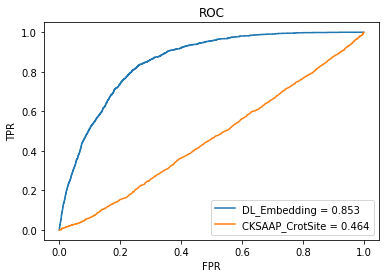

In [85]:
# DL-embedding 与 CKSAAP_CrotSite的性能比较
q = ['Embedding','CKSAAP_CrotSite']
q2=[0.853252]
q3=[0.0307755]


data_Embedding = pd.read_table('c:/Users/Crow/Desktop/human_data_12.12/result/DL_result/Test_keras_29_Embedding_ROC01_result.txt')
data_CKSAAP_CrotSite = pd.read_table('C:/Users/Crow/Desktop/result/CKSAAP_sites_ROC01_result.txt')

#data2 = data[data['x-axie']<=0.1]
plt.title('ROC')
plt.plot(data_Embedding['x-axie'], data_Embedding['y-axie'],label='DL_Embedding' + ' = %0.3f'%0.853252)

plt.plot(data_CKSAAP_CrotSite['x-axie'], data_CKSAAP_CrotSite['y-axie'],label='CKSAAP_CrotSite' + ' = %0.3f'%0.4641598974790915)


plt.legend(loc='lower right')
#plt.plot([0,0.1],[0,1],'r--')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.savefig('c:/Users/Crow/Desktop/result/picture/Embedding_CKSAAP_CrotSite_ROC_600.png',dpi=600)
plt.close(0)

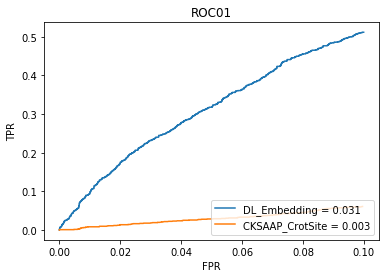

In [86]:
# DL-embedding 与 CKSAAP_CrotSite的性能比较
q = ['Embedding','CKSAAP_CrotSite']
q2=[0.853252]
q3=[0.0307755]


data_Embedding = pd.read_table('c:/Users/Crow/Desktop/human_data_12.12/result/DL_result/Test_keras_29_Embedding_ROC01_result.txt')
data_CKSAAP_CrotSite = pd.read_table('C:/Users/Crow/Desktop/result/CKSAAP_sites_ROC01_result.txt')

data_Embedding2 = data_Embedding[data_Embedding['x-axie']<=0.1]
data_CKSAAP_CrotSite2 = data_CKSAAP_CrotSite[data_CKSAAP_CrotSite['x-axie']<=0.1]
plt.title('ROC01')
plt.plot(data_Embedding2['x-axie'], data_Embedding2['y-axie'],label='DL_Embedding' + ' = %0.3f'%0.0307755)

plt.plot(data_CKSAAP_CrotSite2['x-axie'], data_CKSAAP_CrotSite2['y-axie'],label='CKSAAP_CrotSite' + ' = %0.3f'%0.003)


plt.legend(loc='lower right')
#plt.plot([0,0.1],[0,1],'r--')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.savefig('c:/Users/Crow/Desktop/result/picture/Embedding_CKSAAP_CrotSite_ROC01_600.png',dpi=600)
plt.close(0)

In [11]:
# linshi
# 2019.3.11
# 读取文档 获得 AUC
name='CKSAAP'
gap='_gap4'
a = []
b = []
for i in range(1,11):
    path = 'C:/Users/Crow/Desktop/new_result/CNN/result/29_kfold_CNN_'+name+gap+'_result_ROC01_result_'+str(i)+'.txt'
    fr = open(path,'r')
    for line in fr.readlines()[0:1]:
        print(line.split(':')[1].split('\n')[0])
        a.append(float(line.split(':')[1].split('\n')[0]))
        print(',')
    fr.close()
    fr = open(path,'r')
    for line in fr.readlines()[1:2]:
        print(line.split(':')[1].split('\n')[0])
        b.append(float(line.split(':')[1].split('\n')[0]))
        print(',')
    fr.close()
    #print('\n')

 0.706052
,
 0.0169484
,
 0.690526
,
 0.0169848
,
 0.715062
,
 0.0179932
,
 0.713427
,
 0.0176782
,
 0.710977
,
 0.0155117
,
 0.699106
,
 0.0163995
,
 0.713093
,
 0.0190318
,
 0.728365
,
 0.0206726
,
 0.736651
,
 0.0184324
,
 0.705442
,
 0.0173075
,


In [14]:
a

[0.706052,
 0.690526,
 0.715062,
 0.713427,
 0.710977,
 0.699106,
 0.713093,
 0.728365,
 0.736651,
 0.705442]

In [15]:
b

[0.0169484,
 0.0169848,
 0.0179932,
 0.0176782,
 0.0155117,
 0.0163995,
 0.0190318,
 0.0206726,
 0.0184324,
 0.0173075]

In [16]:
name='CKSAAp'
gap='_gap4'
a = []
b = []
for i in range(1,11):
    path = 'C:/Users/Crow/Desktop/new_result/CNN/result/29_kfold_CNN_'+name+gap+'_result_ROC_result_'+str(i)+'.txt'
    result = pd.read_table(path)
    for i in range(0,len(result)):
        if result['Sp'][i] >= 0.9 and result['Sp'][i+1] <0.9:
            #print("Sp:  %f "  %result['Sp'][i])
            a.append(result['Sp'][i])
            #print("Cutoff:  %f "  %result['<<Cutoff'][i])
            b.append(result['<<Cutoff'][i])

C:\Users\Crow\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  import sys


In [17]:
a

[0.900134,
 0.9000450000000001,
 0.9,
 0.9,
 0.90012,
 0.9000450000000001,
 0.900015,
 0.900075,
 0.9000889999999999,
 0.900015]

In [18]:
b

[0.19909200000000002,
 0.23067,
 0.21955100000000002,
 0.208021,
 0.223388,
 0.24653200000000003,
 0.22803800000000002,
 0.209202,
 0.230325,
 0.24370300000000003]

In [19]:
# 十折交叉检验 RF 2019.3.11
name='CKSAAP'
gap='_gap4'
test_cutoff = [0.19909200000000002,0.23067,0.21955100000000002,0.208021,0.223388,0.24653200000000003,0.22803800000000002,0.209202,0.230325,0.24370300000000003] 


acc = []
sn = []
sp = []
mcc = []
AUC = []
for q in range(1,11):
    path = 'C:/Users/Crow/Desktop/new_result/CNN/29_kfold_CNN_'+name+gap+'_result_'+str(q)+'.txt'
    test_path = 'C:/Users/Crow/Desktop/new_result/CNN/29_kfold_CNN_'+name+gap+'_test_'+str(q)+'.txt'
    y_test = pd.read_table(test_path, header=None)
    y_test = list(y_test[0])
    
    test_result = pd.read_table(path, header=None)
    test_result_score = test_result[0]
    test_pred = np.array(test_result[1])
    
    for i in range(0,len(test_result_score)):
        if test_result_score[i] > test_cutoff[q-1]:       
            test_pred[i] = 1
        else:
            test_pred[i] = 0
    #test_pred = test_pred[1 if test_result_score[i] > test_cutoff[q] else 0 for i in range(0,len(test_result_score))]
    fpr, tpr, thresholds = roc_curve(y_test,test_result_score,pos_label=1)
    precision,recall,SN,SP,GM,TP,TN,FP,FN = performance(y_test,test_pred)
    print("ACC:  %f "  %accuracy_score(y_test,test_pred))
    acc.append(accuracy_score(y_test,test_pred))
    print("Sn: %f" %SN)
    sn.append(SN)
    print("Sp: %f" %SP)
    sp.append(SP)
    print("MCC: %f " %matthews_corrcoef(y_test,test_pred))
    mcc.append(matthews_corrcoef(y_test,test_pred))
    print("AUC: %f" % auc(fpr, tpr))
    print("AUC: %f" % roc_auc_score(y_test,test_result_score))
    AUC.append(auc(fpr, tpr))



C:\Users\Crow\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  from ipykernel import kernelapp as app
C:\Users\Crow\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


ACC:  0.843089 
Sn: 0.281938
Sp: 0.900134
MCC: 0.164146 
AUC: 0.706052
AUC: 0.706052
ACC:  0.846070 
Sn: 0.284389
Sp: 0.900045
MCC: 0.162811 
AUC: 0.690526
AUC: 0.690526
ACC:  0.846070 
Sn: 0.305970
Sp: 0.900000
MCC: 0.182962 
AUC: 0.715062
AUC: 0.715062
ACC:  0.844152 
Sn: 0.310443
Sp: 0.900000
MCC: 0.189686 
AUC: 0.713427
AUC: 0.713427
ACC:  0.843881 
Sn: 0.298119
Sp: 0.900269
MCC: 0.178953 
AUC: 0.710977
AUC: 0.710977
ACC:  0.845643 
Sn: 0.277090
Sp: 0.900193
MCC: 0.156867 
AUC: 0.699106
AUC: 0.699106
ACC:  0.846863 
Sn: 0.329942
Sp: 0.900015
MCC: 0.204712 
AUC: 0.713093
AUC: 0.713093
ACC:  0.849031 
Sn: 0.341246
Sp: 0.900075
MCC: 0.212446 
AUC: 0.728365
AUC: 0.728365
ACC:  0.846592 
Sn: 0.313522
Sp: 0.900089
MCC: 0.189664 
AUC: 0.736651
AUC: 0.736651
ACC:  0.850251 
Sn: 0.305825
Sp: 0.900015
MCC: 0.177255 
AUC: 0.705442
AUC: 0.705442


In [20]:
acc

[0.843089430894309,
 0.846070460704607,
 0.846070460704607,
 0.8441523241631658,
 0.8438812847269278,
 0.8456430410624746,
 0.8468627185255455,
 0.8490310340154492,
 0.8465916790893075,
 0.8502507114785202]

In [21]:
sn

[0.28193832599118945,
 0.28438948995363217,
 0.30597014925373134,
 0.3104434907010014,
 0.2981186685962373,
 0.2770897832817337,
 0.32994186046511625,
 0.34124629080118696,
 0.3135215453194651,
 0.3058252427184466]

In [22]:
mcc


[0.16414635754809995,
 0.1628108870292547,
 0.1829618848879912,
 0.1896856768555791,
 0.17895258740343364,
 0.15686731674561818,
 0.2047123228051748,
 0.21244619771482817,
 0.18966410567140335,
 0.17725464239046393]

In [29]:
CKSAAP_gap4 = [0.706052,0.690526,0.715062,0.713427,0.710977,0.699106,0.713093,0.728365,0.736651,0.705442]
CKSAAP_gap4_01 = [0.0169484,0.0169848,0.0179932,0.0176782,0.0155117,0.0163995,0.0190318,0.0206726,0.0184324,0.0173075]
CKSAAP_gap4_sp = [0.900134,0.9000450000000001,0.9,0.9,0.90012,0.9000450000000001,0.900015,0.900075,0.9000889999999999,0.900015]
CKSAAP_gap4_cutoff = [0.19909200000000002,0.23067,0.21955100000000002,0.208021,0.223388,0.24653200000000003,0.22803800000000002,0.209202,0.230325,0.24370300000000003] 
CKSAAP_gap4_acc = [0.843089430894309,0.846070460704607,0.846070460704607,0.8441523241631658,0.8438812847269278,0.8456430410624746,0.8468627185255455,0.8490310340154492,0.8465916790893075,0.8502507114785202]
CKSAAP_gap4_sn = [0.28193832599118945,0.28438948995363217,0.30597014925373134,0.3104434907010014,0.2981186685962373,0.2770897832817337,0.32994186046511625,0.34124629080118696,0.3135215453194651,0.3058252427184466]
CKSAAP_gap4_mcc = [0.16414635754809995,0.1628108870292547,0.1829618848879912,0.1896856768555791,0.17895258740343364,0.15686731674561818,0.2047123228051748,0.21244619771482817,0.18966410567140335,0.17725464239046393]
mean(CKSAAP_gap4_mcc)

0.18195019790518469

In [29]:
BINARY = [0.747689,0.727972,0.735877,0.751765,0.757011,0.717918,0.749022,0.754958,0.74513,0.726439]
BINARY_01 = [0.0207467,0.0191619,0.017333,0.0197314,0.0208088,0.0159896,0.0179048,0.0225105,0.0193714,0.0169962]
BINARY_sp = [0.900134,0.9000450000000001,0.9,0.9,0.90012,0.9000450000000001,0.900015,0.900075,0.9000889999999999,0.900015]
BINARY_cutoff = [0.23305900000000002,0.24557199999999998,0.213236,0.22940100000000002,0.230094,0.239806,0.22403499999999998,0.200758,0.246743,0.24060399999999998]
BINARY_acc = [0.8497289972899729,0.8482384823848238,0.8455284552845529,0.8456430410624746,0.8479468762704974,0.8451009621899986,0.8474047973980214,0.851199349505353,0.8476758368342594,0.8494375931698062]
BINARY_sn = [0.35389133627019087,0.3075734157650695,0.3,0.32474964234620884,0.3429811866859624,0.2724458204334365,0.33575581395348836,0.36350148367952523,0.32540861812778604,0.2961165048543689]
BINARY_mcc = [0.22360594140823942,0.18212339893070464,0.1780109190876035,0.20183257272854002,0.2159051062860445,0.15278298897387252,0.20948572381489533,0.2306341442280707,0.19943847557203126,0.1694049993902506]
# 获得十折交叉检验结果模型
# 选取AUC最大值的模型，预测全部independent数据集
# 输出result.txt =》得到AUC AUC01 cutoff 
#from keras.models import *
name = 'BINARY'
gap = ''
index = BINARY.index(max(BINARY))

print("index: %d" %index)

acc = []
sn = []
sp = []
mcc = []
AUC = []

model = load_model('C:/Users/Crow/Desktop/new_result/CNN/model/29_kfold_CNN_'+ name+gap+'_'+str(index+1)+'.hdf5')

# path_test =  'C:/Users/Crow/Desktop/human_data_12.12/Independent.txt'
# x_test,y_test = pep(path_test,29-2)

path_test = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_IND/'+ name +'/Test_29_'+ name + gap +'.txt'

test = read_svm(path_test)

x_test = test[0]
y_test = test[1]

x_test = np.expand_dims(x_test, axis=2) 



test_pred_proba = model.predict(x_test)
test_pred = model.predict_classes(x_test)
test_pred = list(test_pred[:,0])
# for i in range(0,len(test_result_score)):
#     if test_result_score[i] > 0.185971:       
#         test_pred[i] = 1
#     else:
#         test_pred[i] = 0
#test_pred = test_pred[1 if test_result_score[i] > test_cutoff[q] else 0 for i in range(0,len(test_result_score))]

fpr, tpr, thresholds = roc_curve(y_test,test_pred_proba,pos_label=1)
precision,recall,SN,SP,GM,TP,TN,FP,FN = performance(y_test,test_pred)
print("ACC:  %f "  %accuracy_score(y_test,test_pred))
#acc.append(accuracy_score(y_test,test_pred))
print("Sn: %f" %SN)
#sn.append(SN)
print("Sp: %f" %SP)
#sp.append(SP)
print("MCC: %f " %matthews_corrcoef(y_test,test_pred))
#mcc.append(matthews_corrcoef(y_test,test_pred))
print("AUC: %f" % auc(fpr, tpr))
print("AUC: %f" % roc_auc_score(y_test,test_pred_proba))
#AUC.append(auc(fpr, tpr))
fw = open('C:/Users/Crow/Desktop/new_result/CNN/ind_result/29_kfold_CNN_'+ name + gap +'_result.txt','w')
for t in range(0,len(test_pred_proba)):
    fw.write(str(test_pred_proba[t][0]))
    fw.write('\t')
    fw.write(str(y_test[t]))
    fw.write('\n')
fw.close()




index: 4


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv1d_55/convolution/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv1d_55/convolution/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer, conv1d_55/convolution/ExpandDims_1)]]
	 [[{{node dense_19/Sigmoid/_267}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_166_dense_19/Sigmoid", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]